# Treating Dataframes containing cocktails data

## Import & Defines

In [1]:
import time
import os
from IPython import display
import pandas as pd
import requests

# Convert a time in seconds in a string of type hh:mm:ss
def hmsString(seconds) : 
    h = int(seconds / (60 * 60))
    m = int((seconds % (60 * 60)) / 60)
    s = seconds % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

import string
import xml
import re
import sys

In [2]:
dfRecipePathToUse = "../difford/recipes.pkl"
dfIngredientsPathToUse = "../difford/ingredients.pkl"

dfRecipes = pd.read_pickle(dfRecipePathToUse)
dfIngredients = pd.read_pickle(dfIngredientsPathToUse)

## Functions

### Ingredients

In [176]:
import operator

def makeStringCamelCaseAndUpperCase(string) :
    result = ""
    word = ""
    endReplacements = ["'s " ]
    for c in string :
        if word == "" :
            word += c.upper()
        else :
            word += c
        if ((c.lower() == c.upper()) and (c not in "")) :
            result += word
            word = ""
    result += word
    for repl in endReplacements :
        result.replace(repl.upper(), repl.lower())
    return result

def getIngredientsInDf(df) :
    totalItems = len(df.index)
    totalItemsString = "{:,}".format(totalItems).replace(",", " ")
    itemCount = 0
    startTime = time.time()
    printEvery = 100
    
    ingredients = dict()
    
    for index, row in df.iterrows() :
        
        for key in row["ingredients"] :
            newKey = makeStringCamelCaseAndUpperCase(key)
            if newKey in ingredients.keys() :
                ingredients[newKey] += 1
            else :
                ingredients[newKey] = 1
        
        itemCount += 1 

        if (itemCount > 0 and itemCount % printEvery == 0) or itemCount == totalItems :
            countItemsString = "{:,}".format(itemCount).replace(",", " ")
            percentageString = "{:.4}%".format(100.0 * itemCount / totalItems)
            timeElapsed = time.time() - startTime
            eta = int((totalItems - itemCount) * timeElapsed / itemCount)
            string = (f"{countItemsString} / {totalItemsString} done ({percentageString})" + 
                f" > {hmsString(timeElapsed)} : {hmsString(eta)} ({hmsString(timeElapsed + eta)})")
            display.clear_output(wait=True)
            print(string)
            
    return dict(sorted(ingredients.items(), key=operator.itemgetter(1),reverse=True))

In [182]:
ingredients = getIngredientsInDf(dfRecipes)
ingredients

4 802 / 4 802 done (100.0%) > 0:00:00.94 : 0:00:00.00 (0:00:00.94)


{'Sugar Syrup (Rich) 2 Sugar To 1 Water': 1151,
 'Lime Juice (Freshly Squeezed)': 1084,
 'Lemon Juice (Freshly Squeezed)': 1059,
 'Rutte Dry Gin': 784,
 'Ketel One Vodka': 558,
 'Angostura Aromatic Bitters': 492,
 'Bacardi Carta Blanca Light Rum': 462,
 'Cognac': 447,
 'Martini Extra Dry Vermouth': 397,
 'Orange Juice (Freshly Squeezed)': 376,
 'Martini Rosso Sweet Vermouth': 357,
 'De Kuyper Triple Sec (40%)': 347,
 'Pineapple Juice (Fresh Pressed)': 327,
 'Bourbon Whiskey': 300,
 'Orange Bitters By Angostura': 294,
 'Pasteurised Egg White': 258,
 'Patrón Reposado Tequila': 223,
 'Thomas Henry Soda Water': 223,
 'Giffard Grenadine Syrup': 222,
 'Chilled Water (Omit If Using Wet Ice)': 219,
 'Apple Juice (Cloudy Pressed)': 219,
 'La Fée Parisienne Absinthe': 200,
 'Grapefruit Juice (Pink)': 199,
 'Cranberry Juice': 199,
 'Luxardo Maraschino Liqueur': 196,
 'Italian Red Bitter Liqueur': 177,
 "Dewar'S 12 Year Old Scotch Whisky": 175,
 'St-Germain Elderflower Liqueur': 175,
 'Single Crea

In [193]:
dfIngredients = pd.DataFrame.from_dict(ingredients, orient="index")
dfIngredients["name"] = dfIngredients.index
dfIngredients["index"] = range(len(dfIngredients.index))
dfIngredients = dfIngredients.set_index("index")
dfIngredients = dfIngredients.rename(columns={0 : "recipeAmt"})
dfIngredients.to_pickle("../difford/ingredients.pkl")

In [161]:
def groupIngredientsByClass(ingredients) :
    totalItems = len(ingredients.keys())
    totalItemsString = "{:,}".format(totalItems).replace(",", " ")
    itemCount = 0
    startTime = time.time()
    printEvery = 5
    
    groupedIngredients = dict()
    
    for key in ingredients.keys() :
        
        amountOfCocktailsUsingThisIngredient = ingredients[key]
        
        notClassedYet = True
        
        for k in groupedIngredients.keys() :
            if k in key :
                notClassedYet = False
                newKey = key.replace(k, "???")
                groupedIngredients[k]["total"] += amountOfCocktailsUsingThisIngredient
                groupedIngredients[k][newKey] = amountOfCocktailsUsingThisIngredient
                
        if notClassedYet :
            groupedIngredients[key] = dict()
            groupedIngredients[key]["total"] = amountOfCocktailsUsingThisIngredient
            groupedIngredients[key]["???"] = amountOfCocktailsUsingThisIngredient
        
        itemCount += 1 

        if (itemCount > 0 and itemCount % printEvery == 0) or itemCount == totalItems :
            countItemsString = "{:,}".format(itemCount).replace(",", " ")
            percentageString = "{:.4}%".format(100.0 * itemCount / totalItems)
            timeElapsed = time.time() - startTime
            eta = int((totalItems - itemCount) * timeElapsed / itemCount)
            string = (f"{countItemsString} / {totalItemsString} done ({percentageString})" + 
                f" > {hmsString(timeElapsed)} : {hmsString(eta)} ({hmsString(timeElapsed + eta)})")
            display.clear_output(wait=True)
            print(string)
            
    return dict(sorted(groupedIngredients.items(), key=lambda x : x[1]["total"],reverse=True))

In [162]:
groupedIngredients = groupIngredientsByClass(ingredients)

862 / 862 done (100.0%) > 0:00:00.30 : 0:00:00.00 (0:00:00.30)


In [160]:
groupedIngredients

{'Sugar Syrup (Rich) 2 Sugar To 1 Water': {'total': 1170,
  '???': 1151,
  '??? (Optional)': 11,
  '??? (2 Sugar To 1 Water)': 7,
  '??? (Chilled)': 1},
 'Lime Juice (Freshly Squeezed)': {'total': 1085,
  '???': 1084,
  '??? (Clarified)': 1},
 'Lemon Juice (Freshly Squeezed)': {'total': 1059, '???': 1059},
 'Rutte Dry Gin': {'total': 788,
  '???': 784,
  '??? (From Freezer)': 2,
  '??? (Tea Infused)': 1,
  '??? (Infused With Earl Grey Tea)': 1},
 'Cognac': {'total': 613,
  '???': 447,
  'Grand Marnier Or Other ??? Orange Liqueur': 165,
  '??? (Infused With Vanilla)': 1},
 'Ketel One Vodka': {'total': 566,
  '???': 558,
  '??? (Infused With Vanilla)': 5,
  '??? (Infused With Lavender)': 2,
  '??? (Chopped Wedges)': 1},
 'Angostura Aromatic Bitters': {'total': 503,
  '???': 492,
  '??? (Optional)': 11},
 'Bacardi Carta Blanca Light Rum': {'total': 470,
  '???': 462,
  '??? (Infused With Vanilla)': 7,
  '??? (Cinnamon Infused)': 1},
 'Martini Extra Dry Vermouth': {'total': 399,
  '???': 3

In [58]:
import operator
def getIngredientsComplement(groupedIngredients) :
    totalItems = len(groupedIngredients.keys())
    totalItemsString = "{:,}".format(totalItems).replace(",", " ")
    itemCount = 0
    startTime = time.time()
    printEvery = 10
    
    ingredientComplements = dict()
    
    for k in groupedIngredients.keys() :
        
        for key in groupedIngredients[k].keys() :
            if (key == "total" or key == "???") :
                continue
            elif key in ingredientComplements.keys() :
                ingredientComplements[key] += 1
            else :
                ingredientComplements[key] = 1
        
        itemCount += 1 

        if (itemCount > 0 and itemCount % printEvery == 0) or itemCount == totalItems :
            countItemsString = "{:,}".format(itemCount).replace(",", " ")
            percentageString = "{:.4}%".format(100.0 * itemCount / totalItems)
            timeElapsed = time.time() - startTime
            eta = int((totalItems - itemCount) * timeElapsed / itemCount)
            string = (f"{countItemsString} / {totalItemsString} done ({percentageString})" + 
                f" > {hmsString(timeElapsed)} : {hmsString(eta)} ({hmsString(timeElapsed + eta)})")
            display.clear_output(wait=True)
            print(string)
            
    return dict(sorted(ingredientComplements.items(), key=operator.itemgetter(1),reverse=True))

In [59]:
getIngredientsComplement(groupedIngredients)

750 / 750 done (100.0%) > 0:00:00.11 : 0:00:00.00 (0:00:00.11)


{'??? (optional)': 24,
 '??? (chopped)': 14,
 '??? (infused with vanilla)': 5,
 '??? (chilled)': 4,
 '??? (from freezer)': 4,
 '??? (chopped wedges)': 3,
 '??? (white)': 3,
 '??? (cut into segments)': 3,
 '??? (infused with Earl Grey tea)': 2,
 '??? (infused with lavender)': 2,
 '??? (bacon fat washed)': 2,
 '??? sugar syrup': 2,
 '??? (cored, skinned and chopped)': 2,
 '??? (2 sugar to 1 water)': 1,
 '??? (clarified)': 1,
 '??? (tea infused)': 1,
 '??? (cinnamon infused)': 1,
 '??? (originally  Ambre)': 1,
 '??? (grapefruit infused)': 1,
 '??? (Star anise infused)': 1,
 '??? (or ginger ale)': 1,
 '??? (omit for Cocktails Made Easy)': 1,
 '??? syrup (3 honey to 1 water)': 1,
 '??? liqueur (spiced)': 1,
 '??? water (1:1)': 1,
 '??? flavoured vodka': 1,
 'Barenjager ??? liqueur': 1,
 'Melon (???dew)': 1,
 '??? (infused with strawberry)': 1,
 '??? (infused with red florina pepper)': 1,
 '??? (reduce if wet ice)': 1,
 '??? (infused with coffee beans)': 1,
 '??? (infused with tamarind)': 1,

#### Factorize

In [577]:
def testSubstring(substring, increments, delimiters = "", secondaryCategories = [], limitSize = 0, 
                  metachar = None, depth = -1) :
    forbiddenSubstrings = []
    if ((metachar != None) and (depth != -1)) :
        currentMetacharString = f"{metachar}{depth}{metachar}"
        forbiddenSubstrings.append(currentMetacharString)
    # Return result of interests (descending)
    result = 0
    
    # Pre-Processing
    for string in forbiddenSubstrings :
        substring = substring.replace(string,"")
    
    oldSubstring = ""
    while oldSubstring != substring :
        oldSubstring = substring
        substring = substring.replace("  ", " ")
        
    
    # Treating Errors -> -1
    if (len(substring) <= 0) :
        result = increments["useless"]
        return result
    for i in range(len(substring) + 1) :
        if i >= len(substring) :
            result = increments["useless"]
            return result
        if (substring[i].lower() != substring[i].upper()) :
            break
    # Length -> X000
    effectiveLength = 0
    for c in substring :
        if c not in delimiters :
            effectiveLength += 1
    if (effectiveLength >= limitSize) :
        result += increments["limitSize"]
    # Has Capital Letter -> 00X0 && Delimiters -> 000X
    if (substring[0] in delimiters) :
        result += increments["delimiters"]
        if ((len(substring) >= 2) and (substring[1].upper() == substring[1])) :
            result += increments["hasCapital"]
    else :
        if (substring[0].upper() == substring[0]) :
            result += increments["hasCapital"]
    if (substring[-1] in delimiters) :
            result += increments["delimiters"]
    # Secondary Categories -> X000
    result += increments["secondaryCategories"]
    for string in secondaryCategories :
        if (string.lower() in substring.lower()) :
            result -= increments["secondaryCategories"]
            break
        
    return result
    
def findAllSubstrings(string1, string2, increments, delimiters = "", secondaryCategories = [], limitSize = 0, 
                  metachar = None, depth = -1):
    answers = dict()
    
    stringBoundariesChar = "§"
    
    if (stringBoundariesChar in string1) :
        raise ValueError(f"stringBoundariesChar('{stringBoundariesChar}') in string1('{string1}')") 
    else :
        string1 = f"{stringBoundariesChar}{string1}{stringBoundariesChar}"
    if (stringBoundariesChar in string2) :
        raise ValueError(f"stringBoundariesChar('{stringBoundariesChar}') in string2('{string2}')") 
    else :
        string2 = f"{stringBoundariesChar}{string2}{stringBoundariesChar}"
    
    # Remove redundant spaces
    oldString = ""
    while oldString != string1 :
        oldString = string1
        string1 = string1.replace("  ", " ")
    oldString = ""
    while oldString != string2 :
        oldString = string2
        string2 = string2.replace("  ", " ")
    
    len1, len2 = len(string1), len(string2)
    for i in range(len1):
        match = ""
        for j in range(len2):
            k = 0
            while True :
                if ((i + k >= len1) or (j + k >= len2)) :
                    priority = testSubstring(match,increments, delimiters=delimiters, secondaryCategories=secondaryCategories, limitSize=limitSize)
                    if (priority != increments["useless"]) :
                        match = match.replace(stringBoundariesChar, "")
                        if (priority in answers.keys()) :
                            if match not in answers[priority] :
                                answers[priority].append(match)
                        else :
                            answers[priority] = [match]
                    match = ""
                    break
                elif (string1[i + k] == string2[j + k]):
                    match += string2[j + k]
                else:
                    priority = testSubstring(match,increments, delimiters=delimiters, secondaryCategories=secondaryCategories, limitSize=limitSize)
                    if (priority != increments["useless"]) :
                        match = match.replace(stringBoundariesChar, "")
                        if (priority in answers.keys()) :
                            if match not in answers[priority] :
                                answers[priority].append(match)
                        else :
                            answers[priority] = [match]
                    match = ""
                
                k += 1
                
    for key in answers.keys() :
        answers[key] = sorted(answers[key], key = lambda x : len(x), reverse=True)
    
    return answers

def findBestSubstrings(string1, string2, maxNumberOfSubstrings = 1,
                      increments = None, delimiters = None, secondaryCategories = None, limitSize = None, 
                      minPriority = None, metachar = None, depth = -1) :
    results = dict()
    # Default parameters
    if (delimiters == None) :
        delimiters = " -()§"
    if (increments == None) :
        increments = dict({
            "limitSize" : 1000, 
            "hasCapital" : 100, 
            "delimiters" : 10,
            "secondaryCategories" : 1,
            "useless" : -1})
    if (secondaryCategories == None) :
        secondaryCategories = ["light", "dark", "jamaican", "to", "dry", "sweet", "de", "la", 
                           "di", "of", "if", "omit", "optional", "other", "white", "red",
                           "old", "bianco", "grand", "cold", "hot", "fresh", "¤", "water", "sugar", "angostura"]
    if (limitSize == None) :
        limitSize = 3
    if (minPriority == None) :
        minPriority = 1100
        
    # Execution
    substrings = findAllSubstrings(f" {string1} ", f" {string2} ",
                                   increments=increments,
                                   delimiters=delimiters, 
                                   secondaryCategories=secondaryCategories, 
                                   limitSize=limitSize,
                                   metachar = metachar,
                                   depth = depth)
    acceptableSubstrings = sorted([k for k in substrings.keys() if (k >= minPriority)])
    if (len(acceptableSubstrings) != 0) :
        for priority in sorted(acceptableSubstrings, reverse = True) :
            newSubstrings = []
            for substr in sorted(substrings[priority], key = lambda x : len(x), reverse = True) :
                if ((priority - 1) in substrings.keys()) :
                        for candidate in sorted(substrings[priority - 1], key = lambda x : len(x), reverse = True) :
                            print(f"candidate : {candidate} vs {substr}")
                            if substr in candidate :
                                print(f"{candidate} will be promoted")
                                newSubstrings.append(candidate)
            for substr in newSubstrings :
                substrings[priority].append(substr)
            results[priority] = []
            for substr in sorted(substrings[priority], key = lambda x : len(x), reverse = True) :
                results[priority].append(substr)
                maxNumberOfSubstrings -= 1
                if (maxNumberOfSubstrings < 1) :
                    return results
    return results

In [618]:
def fitTerm(dictionnary, term, amountOfCocktailsUsingThisIngredient, minPriority = None, depth = -1, 
            secondariesAllowed = True) :
    metachar = "¤"
    currentMetacharString = f"{metachar}{depth}{metachar}"
    nextMetacharString = f"{metachar}{depth + 1}{metachar}"
    for key in dictionnary.keys() :
        if key == currentMetacharString :
            continue
        if term in key :
            newKey = key.replace(term, nextMetacharString)
            dictionnary[term] = {
                nextMetacharString : amountOfCocktailsUsingThisIngredient,
                newKey : dictionnary[key]
            }
            dictionnary.pop(key)
            return {
                "dict" : dictionnary,
                "string" : f"|0| -> '{term}' (('{key}'))"
            }
                
        elif key in term :
            newKey = term.replace(key, nextMetacharString)
            if type(dictionnary[key]) == dict :
                result = fitTerm(dictionnary[key], 
                                 newKey, 
                                 amountOfCocktailsUsingThisIngredient, 
                                 minPriority = minPriority, 
                                 depth = depth + 1, 
                                 secondariesAllowed = secondariesAllowed)
                resultDict = result["dict"]
                resultString = result["string"]
                dictionnary[key] = resultDict
                return {
                    "dict" : dictionnary,
                    "string" : f"|1| -> '{key}'{resultString}"
                }
            else :
                dictionnary[key] = {
                    newKey : amountOfCocktailsUsingThisIngredient,
                    nextMetacharString : dictionnary[key]
                }
                return {
                    "dict" : dictionnary,
                    "string" : f"|2| -> '{key}' -> '{newKey}'"
                }
            
    commonSubstrings = dict()
    for key in dictionnary.keys() :
        if key == currentMetacharString :
            continue
        substrings = findBestSubstrings(term, key, 
                                        minPriority = minPriority, metachar = metachar, depth = depth)
        for priority in substrings.keys() :
            if priority not in commonSubstrings.keys() :
                commonSubstrings[priority] = dict()
            for substr in substrings[priority] :
                commonSubstrings[priority][substr] = key
    
    for priority in sorted(commonSubstrings.keys(), reverse = True) :
        if (minPriority == None or priority >= minPriority) and (secondariesAllowed or (priority % 10 == 1)) :
            for substring in sorted(commonSubstrings[priority].keys(), key = lambda x : len(x) , reverse = True) :
                if len(substr) > 0 :
                    # print(f"substring = {substring}, priority = {priority}")
                    root = substring
                    
                    if root[0] == " " :
                        root = root[1:]
                    if root[-1] == " " :
                        root = root[:-1]
                    key = commonSubstrings[priority][substring]
                    newKey = key.replace(root, nextMetacharString)
                    newTerm = term.replace(root, nextMetacharString)
                    dictionnary[root] = {
                        newKey : dictionnary[key],
                        newTerm : amountOfCocktailsUsingThisIngredient
                    }
                    dictionnary.pop(key)
                    return {
                        "dict" : dictionnary,
                        "string" : f"|3| -> '{root} ({priority})' -> '{newTerm}' (('{key}'))"
                    }
                
    dictionnary[term] = amountOfCocktailsUsingThisIngredient
    if (depth == -1) :
        return {
            "dict" : dictionnary,
            "string" : f"|4| => '{term}'"
        }
    else :
        return {
            "dict" : dictionnary,
            "string" : f"|5| -> '{term}'"
        }
            
        
    

def factorize(ingredients, limit = -1, minPriority = None) :
    # Step 1
    if limit < 0 :
        totalItems = len(ingredients.keys())
    else :
        totalItems = min(len(ingredients.keys()), limit)
    totalItemsString = "{:,}".format(totalItems).replace(",", " ")
    itemCount = 0
    startTime = time.time()
    printEvery = 5
    
    if minPriority % 10 == 0 :
        minPriority += 1
        
    complexityPower = 2  # for eta
    
    groupedIngredients = dict()
    
    toPrint = []
    
    for key in ingredients.keys() :
        
        amountOfCocktailsUsingThisIngredient = ingredients[key]
        
        notClassedYet = True
        
        result = fitTerm(groupedIngredients, key, amountOfCocktailsUsingThisIngredient, minPriority, 
                         secondariesAllowed = False)
        groupedIngredients = result["dict"]
        if ("=>" not in result["string"]) :
            toPrint.append(f"{itemCount} : '{key}' {result['string']}")
        
        itemCount += 1 

        if (itemCount > 0 and itemCount % printEvery == 0) or itemCount == totalItems :
            countItemsString = "{:,}".format(itemCount).replace(",", " ")
            percentageString = "{:.4}%".format(100.0 * itemCount / totalItems)
            timeElapsed = time.time() - startTime
            eta = int((totalItems ** complexityPower - itemCount ** complexityPower) * timeElapsed / (itemCount ** complexityPower))
            string = (f"{countItemsString} / {totalItemsString} done ({percentageString})" + 
                f" > {hmsString(timeElapsed)} : {hmsString(eta)} ({hmsString(timeElapsed + eta)})")
            display.clear_output(wait=True)
            print(f"Step 1 : {string}")
            lastStringStep1 = string
            print("############################################")
            for string in toPrint :
                print(string)
            
        if ((limit > 0) and (itemCount >= limit)) :
            break
    
    # Step 2
    aloneIngredients = dict()
    for k in groupedIngredients.keys() :
        if (type(groupedIngredients[k]) == int) :
            aloneIngredients[k] = groupedIngredients[k] 
        
    lenAlreadyGrouped = len(ingredients) - len(aloneIngredients)
            
    totalItems = len(aloneIngredients.keys())
    totalItemsString = "{:,}".format(totalItems).replace(",", " ")
    itemCount = 0
    startTime = time.time()
    printEvery = 5
    
    minPriority -= 1
    
    toPrint.append("----------------------------------------------")
    
    alreadyGrouped = []
    
    for key in aloneIngredients.keys() :
        
        if key not in alreadyGrouped :
        
            amountOfCocktailsUsingThisIngredient = aloneIngredients[key]

            if key in groupedIngredients.keys() :
                groupedIngredients.pop(key)

            result = fitTerm(groupedIngredients, key, amountOfCocktailsUsingThisIngredient, minPriority, 
                             secondariesAllowed = True)
            groupedIngredients = result["dict"]
            alreadyGrouped.append(result["string"].split("(('")[-1].replace("'))", ""))
            if ("=>" not in result["string"]) :
                toPrint.append(f"{itemCount} : '{key}' {result['string']}")
        
        itemCount += 1 

        if (itemCount > 0 and itemCount % printEvery == 0) or itemCount == totalItems :
            countItemsString = "{:,}".format(itemCount).replace(",", " ")
            percentageString = "{:.4}%".format(100.0 * (itemCount / totalItems))
            timeElapsed = time.time() - startTime
            eta = int((totalItems * lenAlreadyGrouped - itemCount * lenAlreadyGrouped) * timeElapsed / (itemCount ** lenAlreadyGrouped))
            string = (f"{countItemsString} / {totalItemsString} done ({percentageString})" + 
                f" > {hmsString(timeElapsed)} : {hmsString(eta)} ({hmsString(timeElapsed + eta)})")
            display.clear_output(wait=True)
            print(f"Step 1 : {lastStringStep1}")
            print(f"Step 2 : {string}")
            print("############################################")
            for string in toPrint :
                print(string)
            
        if ((limit > 0) and (itemCount >= limit)) :
            break
    
            
    return dict(groupedIngredients.items())

def computeTotals(dictionary) :
    total = 0
    for key in dictionary.keys() :
        if key == "total" :
            continue
        if type(dictionary[key]) == dict :
            result = computeTotals(dictionary[key])
            dictionary[key] = result
            total += dictionary[key]["total"]
        elif type(dictionary[key]) == int :
            total += dictionary[key]
        else :
            raise TypeError(f"dictionnary[key] (key = '{key}') is of type '{type(dictionary[key])}'")
    dictionary["total"] = total
    return dictionary

def factorizeAllIngredients(ingredients, limit = -1, minPriority = None) :
    groupedIngredients = factorize(ingredients, limit = limit, minPriority = minPriority)
    groupedIngredients = computeTotals(groupedIngredients).pop("total")
    return dict(sorted(groupedIngredients.items(), reverse = False))


In [619]:
test = factorizeAllIngredients(ingredients, limit = -1, minPriority = 1120)

Step 1 : 862 / 862 done (100.0%) > 0:03:54.57 : 0:00:00.00 (0:03:54.57)
############################################
2 : 'Lemon Juice (Freshly Squeezed)' |3| -> 'Juice (Freshly Squeezed) (1121)' -> 'Lemon ¤0¤' (('Lime Juice (Freshly Squeezed)'))
9 : 'Orange Juice (Freshly Squeezed)' |1| -> 'Juice (Freshly Squeezed)'|5| -> 'Orange ¤0¤'
10 : 'Martini Rosso Sweet Vermouth' |3| -> 'Vermouth (1121)' -> 'Martini Rosso Sweet ¤0¤' (('Martini Extra Dry Vermouth'))
14 : 'Orange Bitters By Angostura' |3| -> 'Bitters (1121)' -> 'Orange ¤0¤ By Angostura' (('Angostura Aromatic Bitters'))
18 : 'Giffard Grenadine Syrup' |3| -> 'Syrup (1121)' -> 'Giffard Grenadine ¤0¤' (('Sugar Syrup (Rich) 2 Sugar To 1 Water'))
20 : 'Apple Juice (Cloudy Pressed)' |3| -> 'Pressed) (1121)' -> 'Apple Juice (Cloudy ¤0¤' (('Pineapple Juice (Fresh Pressed)'))
22 : 'Grapefruit Juice (Pink)' |3| -> 'Juice ( (1121)' -> 'Grapefruit ¤0¤Pink)' (('Juice (Freshly Squeezed)'))
23 : 'Cranberry Juice' |3| -> 'Juice (1121)' -> 'Cranber

OverflowError: int too large to convert to float

In [620]:
sortingdict(sorted(test.items(), reverse = False))

AttributeError: 'int' object has no attribute 'items'

In [627]:
def sortingDictByTotal(x) :
    if type(x) == int : return x
    elif type(x) == dict : return x["total"]
    else : raise TypeError(type(x))
        
dict(sorted(T.items(), key = lambda x : sortingDictByTotal(x[1]),reverse=True))

{'total': 15004,
 'Juice': {'¤0¤ (': {'¤0¤Freshly Squeezed)': {'Lime ¤0¤': 1084,
    'Lemon ¤0¤': 1059,
    'Orange ¤0¤': 376,
    'total': 2519},
   'Grapefruit ¤0¤Pink)': 199,
   'total': 2718},
  'Cranberry ¤0¤': 199,
  'total': 2917},
 'Syrup': {'Sugar ¤0¤ (Rich) 2 Sugar To 1 Water': 1151,
  'Giffard Grenadine ¤0¤': 222,
  'Giffard Orgeat ¤0¤': 91,
  'Agave ¤0¤': 68,
  'Honey ¤0¤ (3 Honey To 1 Water)': 62,
  'Maple ¤0¤': 62,
  'total': 1656},
 'Liqueur': {'Luxardo Maraschino ¤0¤': 196,
  'Italian Red Bitter ¤0¤': 177,
  'St-Germain Elderflower ¤0¤': 175,
  'Coffee ¤0¤': 140,
  'Orange Curaçao ¤0¤': 101,
  'Suze Gentian ¤0¤': 101,
  'Giffard Framboise De Ronce (Black Raspberry ¤0¤)': 100,
  'Green Chartreuse ¤0¤': 95,
  'Cherry Heering Cherry Brandy ¤0¤': 90,
  'Yellow Chartreuse ¤0¤': 73,
  'Falernum ¤0¤': 69,
  'Irish Cream ¤0¤': 66,
  "Galliano L'Autentico ¤0¤": 60,
  'total': 1443},
 'Bitters': {'Angostura Aromatic ¤0¤': 492,
  'Orange ¤0¤ By Angostura': 294,
  "Peychaud'S Or Ot

In [601]:
ingredients["Giffard Cassis Noir De Bourgogne"]

64

In [580]:
delimiters = " -()§"
increments = dict({
            "limitSize" : 1000, 
            "secondaryCategories" : 1,
            "hasCapital" : 100, 
            "delimiters" : 10,  
            "useless" : -1})
secondaryCategories = ["light", "dark", "jamaican", "to", "dry", "sweet", "de", "la", 
                           "di", "of", "if", "omit", "optional", "other", "white", "red",
                           "old", "bianco", "grand", "cold", "hot", "fresh", "???"]
limitSize = 3
minPriority = 0
print(sorted(findAllSubstrings("Lemon Juice (Freshly Squeezed)", "Lime Juice (Freshly Squeezed)", delimiters = delimiters,
    increments = increments,
    secondaryCategories = secondaryCategories,
    limitSize = limitSize).items(), reverse = True))

[(1121, [' Squeezed)']), (1120, [' Juice (Freshly Squeezed)', ' (Freshly Squeezed)', '(Freshly Squeezed)']), (1111, ['Squeezed)']), (1110, ['Juice (Freshly Squeezed)', 'Freshly Squeezed)']), (1011, ['reshly Squeezed)', 'eshly Squeezed)', 'shly Squeezed)', 'hly Squeezed)', 'ly Squeezed)', 'y Squeezed)', 'queezed)', 'ueezed)', 'eezed)', 'ezed)', 'zed)']), (1010, ['uice (Freshly Squeezed)', 'ice (Freshly Squeezed)', 'ce (Freshly Squeezed)', 'e (Freshly Squeezed)']), (111, ['L']), (101, ['L']), (11, ['ed)', 'e ', 'd)']), (1, ['m', 'e', 'u', 'i'])]


In [581]:
delimiters = " -()§"
increments = dict({
            "limitSize" : 1000, 
            "secondaryCategories" : 1,
            "hasCapital" : 100, 
            "delimiters" : 10,  
            "useless" : -1})
secondaryCategories = ["light", "dark", "jamaican", "to", "dry", "sweet", "de", "la", 
                           "di", "of", "if", "omit", "optional", "other", "white", "red",
                           "old", "bianco", "grand", "cold", "hot", "fresh", "???"]
limitSize = 3
minPriority = 0
print(sorted(findBestSubstrings("Lemon Juice (Freshly Squeezed)", "Lime Juice (Freshly Squeezed)", delimiters = delimiters,
    increments = increments,
    secondaryCategories = secondaryCategories,
    limitSize = limitSize).items(), reverse = True))

candidate :  Juice (Freshly Squeezed)  vs  Squeezed) 
 Juice (Freshly Squeezed)  will be promoted
candidate :  (Freshly Squeezed)  vs  Squeezed) 
 (Freshly Squeezed)  will be promoted
candidate : (Freshly Squeezed)  vs  Squeezed) 
(Freshly Squeezed)  will be promoted
[(1121, [' Juice (Freshly Squeezed) '])]


In [538]:
test

{'Wine': {'Prosecco Sparkling ¤0¤': 56,
  'Sauvignon Blanc White ¤0¤': 50,
  'total': 480},
 'White Crème De': {'Dutch ¤0¤ Cacao': 112, 'total': 448},
 'White Caster Sugar': 35,
 'Whiskey': {'Bourbon ¤0¤': 300,
  'Rye ¤0¤ 100 Proof / 50% Alc./Vol.': 108,
  'Irish ¤0¤': 47,
  'Tennessee ¤0¤': 46,
  'total': 2004},
 'Water': {'Chilled ¤0¤': {'¤0¤': 109,
   '¤0¤ (Omit If Using Wet Ice)': 219,
   'total': 1312},
  'Coconut ¤0¤': 26,
  'total': 3384},
 'Vodka': {'Absolut Vanilia ¤0¤': 53, 'Bison Grass ¤0¤': 50, 'total': 412},
 'Vermouth': {'Martini Extra Dry ¤0¤': 397,
  'Martini': {'¤1¤ Rosso Sweet ¤0¤': 357, '¤1¤ Bianco ¤0¤': 48, 'total': 1620},
  'Antica Formula Or Other Well Aged Sweet ¤0¤': 34,
  'Punt E Mes Or Other Full-Bodied ¤0¤': 25,
  'total': 5874},
 'Thomas Henry': {'¤0¤ Soda Water': 223,
  '¤0¤ Tonic Water': 60,
  'Ginger': {'¤0¤ ¤1¤ Ale': 83, '¤0¤ ¤1¤ Beer': 53, 'total': 544},
  'total': 2492},
 'Tawny Port (10 Year Old)': 60,
 'Syrup': {'Sugar ¤0¤ (Rich) 2 Sugar To 1 Water':

In [301]:
string1, string2 = " abc def ghi Jkl a PQLMN ",  " ab cdef h Jkl PQLMN "
delimiters = " -()"
increments = dict({
    "limitSize" : 1000, 
    "secondaryCategories" : 100,
    "hasCapital" : 10, 
    "delimiters" : 1,  
    "useless" : -1})
secondaryCategories = ["light", "dark", "jamaican", "to", "dry", "sweet", "de", "la", 
                   "di", "of", "if", "omit", "optional", "other", "white", "red",
                   "old", "bianco", "grand", "cold", "hot", "fresh"]
limitSize = 3
minPriority = 0
substrings = findAllSubstrings(string1, string2,
                                   increments=increments,
                                   delimiters=delimiters, 
                                   secondaryCategories=secondaryCategories, 
                                   limitSize=limitSize)
print(substrings)
print("######################################################")
acceptableSubstrings = sorted([k for k in substrings.keys() if (k >= minPriority)])
if (len(acceptableSubstrings) != 0) :
    for priority in sorted(acceptableSubstrings, reverse = True) :
        substr = sorted(substrings[priority], 
                             key = lambda x : len(x), reverse = True)[0]
        print(f"{priority} -> {substr}")

{1101: [' ab'], 1001: ['def '], 100: ['h'], 1112: [' PQLMN ', ' Jkl '], 101: [' a']}
######################################################
1112 ->  PQLMN 
1101 ->  ab
1001 -> def 
101 ->  a
100 -> h


In [309]:
findBestSubstrings(string1, string2, 3)

{1112: [' PQLMN ', ' Jkl '], 1101: [' ab']}

In [280]:
groupedIngredients

{'Sugar Syrup (Rich) 2 Sugar To 1 Water': {'total': 1170,
  '???': 1151,
  '??? (Optional)': 11,
  '??? (2 Sugar To 1 Water)': 7,
  '??? (Chilled)': 1},
 'Lime Juice (Freshly Squeezed)': {'total': 1085,
  '???': 1084,
  '??? (Clarified)': 1},
 'Lemon Juice (Freshly Squeezed)': {'total': 1059, '???': 1059},
 'Rutte Dry Gin': {'total': 788,
  '???': 784,
  '??? (From Freezer)': 2,
  '??? (Tea Infused)': 1,
  '??? (Infused With Earl Grey Tea)': 1},
 'Cognac': {'total': 613,
  '???': 447,
  'Grand Marnier Or Other ??? Orange Liqueur': 165,
  '??? (Infused With Vanilla)': 1},
 'Ketel One Vodka': {'total': 566,
  '???': 558,
  '??? (Infused With Vanilla)': 5,
  '??? (Infused With Lavender)': 2,
  '??? (Chopped Wedges)': 1},
 'Angostura Aromatic Bitters': {'total': 503,
  '???': 492,
  '??? (Optional)': 11},
 'Bacardi Carta Blanca Light Rum': {'total': 470,
  '???': 462,
  '??? (Infused With Vanilla)': 7,
  '??? (Cinnamon Infused)': 1},
 'Martini Extra Dry Vermouth': {'total': 399,
  '???': 3

### Ingredients Properties

In [8]:
dfIngredients = pd.read_pickle("../difford/ingredients.pkl")

In [202]:
dfIngredients["abv"] = [0 for i in range(len(dfIngredients.index))]
dfIngredients

,recipeAmt,name,abv
index,,,
0,1151,Sugar Syrup (Rich) 2 Sugar To 1 Water,0
1,1084,Lime Juice (Freshly Squeezed),0
2,1059,Lemon Juice (Freshly Squeezed),0
3,784,Rutte Dry Gin,0
4,558,Ketel One Vodka,0
...,...,...,...
857,1,Chianti Red Wine,0
858,1,Fig Sugar Syrup,0
859,1,Cucumber Peeled (English) (Chopped),0


In [9]:
dfIngredients[dfIngredients.apply(lambda x : "ginger" in x["name"].lower(), axis=1)]

,recipeAmt,name
index,,
51,83,Thomas Henry Ginger Ale
82,53,Thomas Henry Ginger Beer
102,44,King'S Ginger Liqueur
118,36,Root Ginger (Thumbnail Sized Slice)
155,23,Ginger Sugar Syrup
212,14,Stone'S Original Green Ginger Wine
414,3,Bob'S Ginger Bitters
430,3,Gingerbread Sugar Syrup
517,2,Ginger Cordial (Non-Alcoholic)


## Export to SQL

In [30]:
dfRecipes = pd.read_pickle("../difford/recipes.pkl")
dfIngredients = pd.read_pickle("../difford/ingredients.pkl")

In [59]:
def assignIngredients(recipes, ingredients, limit = 0) :
    if limit < 0 :
        totalItems = len(recipes.index)
    else :
        totalItems = min(len(recipes.index), limit)
    totalItemsString = "{:,}".format(totalItems).replace(",", " ")
    itemCount = 0
    startTime = time.time()
    printEvery = 5
    
    result = {"recipe" : [], "ingredient" : [], "unit" : [], "quantity" : []}
    
    for ind, row in recipes.iterrows() :
        
        for key in row["ingredients"].keys() :
            print(f"{key} ({type(key)})")
            result["recipe"].append(ind)
            result["ingredient"].append(ingredients[ingredients.apply(lambda x : x["name"].lower() == key.lower()
                                                                      , axis = 1)].index[0])
            result["unit"].append(row["ingredients"][key]["unit"])
            result["quantity"].append(row["ingredients"][key]["quantity"])
            
        
        itemCount += 1 

        if (itemCount > 0 and itemCount % printEvery == 0) or itemCount == totalItems :
            countItemsString = "{:,}".format(itemCount).replace(",", " ")
            percentageString = "{:.4}%".format(100.0 * (itemCount / totalItems))
            timeElapsed = time.time() - startTime
            eta = int((totalItems - itemCount ) * timeElapsed / itemCount)
            string = (f"{countItemsString} / {totalItemsString} done ({percentageString})" + 
                f" > {hmsString(timeElapsed)} : {hmsString(eta)} ({hmsString(timeElapsed + eta)})")
            display.clear_output(wait=True)
            print(f"{string}")

        if ((limit > 0) and (itemCount >= limit)) :
            break
            
    return pd.DataFrame(data=result)
            

In [60]:
test = assignIngredients(dfRecipes, dfIngredients, 5)

5 / 5 done (100.0%) > 0:00:00.31 : 0:00:00.00 (0:00:00.31)


In [49]:
dfIngredients[dfIngredients.apply(lambda x : "Dutch" in x["name"], axis = 1)]

,name
40,Dutch White Crème De Cacao


In [62]:
test

,recipe,ingredient,unit,quantity
0,0,3,ml,50
1,0,40,ml,30
2,0,134,ml,30
3,0,2,ml,10
4,1,41,ml,90
5,2,42,ml,45
6,2,8,ml,15
7,2,10,ml,15
8,2,198,ml,10
9,2,24,ml,10


In [65]:
dfRecipes.at[0, "ingredients"]

{'Rutte Dry Gin': {'quantity': '50', 'unit': 'ml'},
 'Dutch White Crème de Cacao': {'quantity': '30', 'unit': 'ml'},
 'Americano Bianco': {'quantity': '30', 'unit': 'ml'},
 'Lemon juice (freshly squeezed)': {'quantity': '10', 'unit': 'ml'}}

In [68]:
for i in [3, 40, 134, 2] :
    print(f"name : '{dfIngredients.at[i, 'name']}'")

name : 'Rutte Dry Gin'
name : 'Dutch White Crème De Cacao'
name : 'Americano Bianco'
name : 'Lemon Juice (Freshly Squeezed)'


## Search

In [2]:
dfRecipes = pd.read_pickle("../difford/recipes.pkl")

In [8]:
for i,r in dfRecipes.iterrows() :
    truc = r["ingredients"]
    for key in truc :
        print(key)
    break

Rutte Dry Gin
Dutch White Crème de Cacao
Americano Bianco
Lemon juice (freshly squeezed)


In [24]:
truc["Rutte Dry Gin"]["quantity"]

'50'

In [3]:
def filterFunctionExactForOneIngredient(ingredient, row) :
    return ingredient in row["ingredients"].keys()

def filterFunctionCaseInsensitiveForOneIngredient(ingredient, row) :
    for k in row["ingredients"].keys() :
        if ingredient.lower() in k.lower() :
            return True
    return False

def filterFunctionInCIForOneIngredient(ingredient, row) :
    for k in row["ingredients"].keys() :
        if (ingredient.lower() in k.lower()) :
            return True
    return False

def filterFunctionExact(parameters, row, mode) :
    if ("+or+" in mode["ingredients"]) :
        for ingredient in parameters["ingredients"] :
            if filterFunctionExactForOneIngredient(ingredient, row) :
                return True
        return False
    else : # and assumed
        for ingredient in parameters["ingredients"] :
            if not filterFunctionExactForOneIngredient(ingredient, row) :
                return False
        return True

def filterFunctionCaseInsensitive(parameters, row, mode) :
    if ("+or+" in mode["ingredients"]) :
        for ingredient in parameters["ingredients"] :
            if filterFunctionCaseInsensitiveForOneIngredient(ingredient, row) :
                return True
        return False
    else : # and assumed
        for ingredient in parameters["ingredients"] :
            if not filterFunctionCaseInsensitiveForOneIngredient(ingredient, row) :
                return False
        return True

def filterFunctionInCI(parameters, row, mode) :
    if ("+or+" in mode["ingredients"]) :
        for ingredient in parameters["ingredients"] :
            if filterFunctionInCIForOneIngredient(ingredient, row) :
                return True
        return False
    else : # and assumed
        for ingredient in parameters["ingredients"] :
            if not filterFunctionInCIForOneIngredient(ingredient, row) :
                return False
        return True

def filterByParameters(df, parameters, mode, minRating = 0) :
    for key in mode.keys() :
        mode[key] = f"+{mode[key]}+"
    df = df[df.apply(lambda x : 
                     "rating" in x.keys() and
                     "publisher" in x["rating"] and 
                     "rating" in x["rating"]['publisher'] and 
                     x['rating']['publisher']['rating'] != None and 
                     x['rating']['publisher']['rating'] > minRating, axis = 1)]
    ratings = []
    for i, r in df.iterrows() :
        ratings.append(r['rating']['publisher']['rating'])
    df["rating"] = ratings
    if ("+ex+" in mode["ingredients"]) :
        return df[df.apply(lambda x : filterFunctionExact(parameters, x, mode), axis = 1)]
    elif ("+ci+" in mode["ingredients"]) :
        return df[df.apply(lambda x : filterFunctionCaseInsensitive(parameters, x, mode), axis = 1)]
    elif ("+in+ci+" in mode["ingredients"]) :
        return df[df.apply(lambda x : filterFunctionInCI(parameters, x, mode), axis = 1)]
    else :
        raise(ValueError(f"Unexpected value for mode ('{mode}')"))

def filterByParametersAndPrint(df, parameters, mode, minRating = 0) :
    for i, r in filterByParameters(df, parameters, mode, minRating).iterrows() :
        print(f"{r['name']} : {r['rating']['publisher']['rating']}")

In [146]:
params = {
        "ingredients" : ["Carta Blanca", "de cacao"]
    }
mode = {
    "ingredients" : "in+ci+and"
}
test = filterByParameters(dfRecipes, params, mode, .8)
test

<ipython-input-145-80ad3740e570>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rating"] = ratings


,name,picture,glass,garnish,instructions,ingredients,rating,downloadedPicture
421,Black Diamond,https://cdn.diffords.com/contrib/stock-images/...,Martini glass,Dust with grated white chocolate,SHAKE all ingredients with ice and fine strain...,{'Bacardi Carta Blanca light rum': {'quantity'...,0.9,cocktails/difford/pictures/Black_Diamond.jpg
1156,Mulata Daisy,https://cdn.diffords.com/contrib/stock-images/...,Coupe glass,Chocolate powder rim,MUDDLE fennel seeds in the base of shaker. Add...,"{'Fennel seeds': {'quantity': '1', 'unit': 'sp...",0.9,cocktails/difford/pictures/Mulata_Daisy.jpg


In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def printRecipe(recipe, withPicture = True, printRating = "all") :
    print(f"name = '{recipe['name']}'")
    print(f"glass = '{recipe['glass']}'")
    print(f"garnish = '{recipe['garnish']}'")
    print(f"instructions = '{recipe['instructions']}'")
    if (printRating = "all") :
        print(f"rating = '{recipe['rating']}'")
    else :
        try :
            if (printRating in recipe["rating"].keys()) :
                print(f"rating = '{recipe['rating'][printRating]}'")
            else :
                raise ValueError(f"{printRating} not in rating")
                
        except AttributeError :
            raise TypeError("'printRating' may not be of type dict")
        except KeyError :
            raise ValueError("'printRating' should be of format {'type' : '...', 'name' : '...'}")
    if (withPicture) :
        img = mpimg.imread(recipe["downloadedPicture"])
        imgplot = plt.imshow(img)
        plt.show()

    print("ingredients =")
    d = recipe["ingredients"]
    for k in d.keys() :
        print(f" - {d[k]['quantity']} {d[k]['unit']} {k}")
        
def printNRecipesAtATime(filteredDf, minRating = 0, nRecipe = 1, printRating = "all") :
    instructionString = "'q' to quit\na number to set the number of recipe to print\nPress any key to continue..."
    recipeLeftToPrint = nRecipe
    print(f"{len(filteredDf.index)} elements found.")
    
    if (len(filteredDf.index) > 0) :
        npt = input(instructionString)
        instructionString = "'q' to quit\n'+' to increase n ('-' to decrease n)\nPress any key to continue..."

        try :
            integer = int(npt)
            print(integer)
            nRecipe = integer
            recipeLeftToPrint = nRecipe
        except :
            print("")

        display.clear_output(wait=True)

        currentNumber = 0
        totalNumber = len(filteredDf.index)
        
        for i, r in filteredDf.iterrows() :
            
            if (npt == "q") :
                break 
            elif (npt == "+") :
                nRecipe += 1
                recipeLeftToPrint += 1
            elif (npt == "-") :
                if (nRecipe > 1) :
                    nRecipe -= 1
                    recipeLeftToPrint -= 1
            npt = ""

            if (recipeLeftToPrint == 0) :
                display.clear_output(wait=True)
                recipeLeftToPrint = nRecipe
            recipeLeftToPrint -= 1
            
            currentNumber += 1
            print(f"#{currentNumber}/{totalNumber}")
            printRecipe(r, printRating)

            if (i != filteredDf.index[-1]) :

                print("\n---------------------------------------------------------------------------\n")

                if (recipeLeftToPrint == 0) :
                    npt = input(instructionString)
    
       
def filterByParametersAndPrintNRecipeAtATime(df, parameters, mode, minRating = 0, nRecipe = 1) :
    filteredDf = filterByParameters(df, params, mode, minRating)
    printNRecipesAtATime(filteredDf, minRating, nRecipe)


#4/4
name = 'Zubrowka Cocktail'
glass = 'Coupe glass'
garnish = 'Lemon zest twist'
instructions = 'POUR absinthe into ice-filled glass, top with water and stand to one side. Separately STIR other ingredients with ice. Dump contents of glass and strain stirred drink into the absinthe washed glass.'
rating = '0.9'


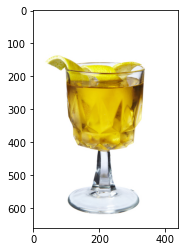

ingredients =
 - 10 ml La Fée Parisienne absinthe
 - 45 ml Bison grass vodka
 - 7.5 ml Cinnamon schnapps & Goldwasser liqueurs
 - 45 ml Martini Rosso sweet vermouth
 - 1 dash Angostura Aromatic Bitters


In [30]:
params = {
        "ingredients" : ["rosso sweet", "vodka"]
    }

mode = {
    "ingredients" : "in+ci+and"
}
test = filterByParametersAndPrintNRecipeAtATime(dfRecipes, params, mode, .8)  

#1/3
name = 'Ginger Cosmo'
glass = 'Coupe glass'
garnish = 'Candied ginger on pick'
instructions = 'SHAKE all ingredients with ice and fine strain into chilled glass.'
rating = '{'publisher': {'name': 'difford', 'rating': 0.9}, 'users': {'n': '2', 'rating': 1.0}}'


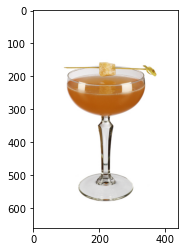

ingredients =
 - 45 ml Ketel One Vodka
 - 15 ml King's Ginger Liqueur
 - 10 ml Ginger sugar syrup
 - 30 ml Cranberry juice
 - 15 ml Lime juice (freshly squeezed)
 - 2 drop Bob's Ginger Bitters

---------------------------------------------------------------------------

'q' to quit
'+' to increase n ('-' to decrease n)
Press any key to continue...q


In [24]:
name = "ginger cosmo"
printNRecipesAtATime(dfRecipes[dfRecipes.apply(lambda x : name.lower() in x["name"].lower(), axis = 1)])

In [23]:
"aifi".keys()

AttributeError: 'str' object has no attribute 'keys'